# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.797400,True,5.966527
1,-0.977541,False,-2.584024
2,0.929717,True,6.430714
3,-0.009700,True,6.410296
4,1.271270,True,7.191493
...,...,...,...
995,-0.291776,False,-0.866438
996,-0.537856,False,-0.216057
997,0.530300,True,8.019742
998,-1.632014,False,-4.037000


<AxesSubplot:xlabel='v0'>

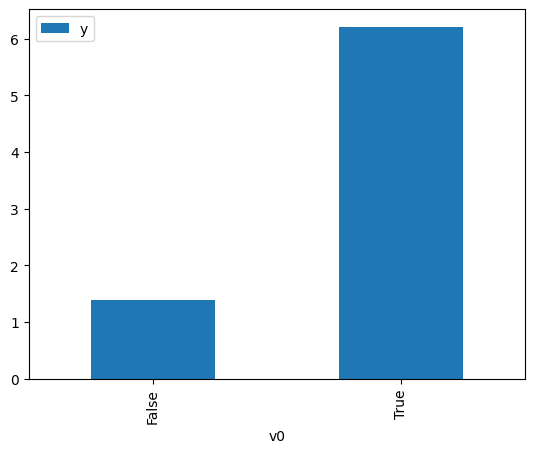

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

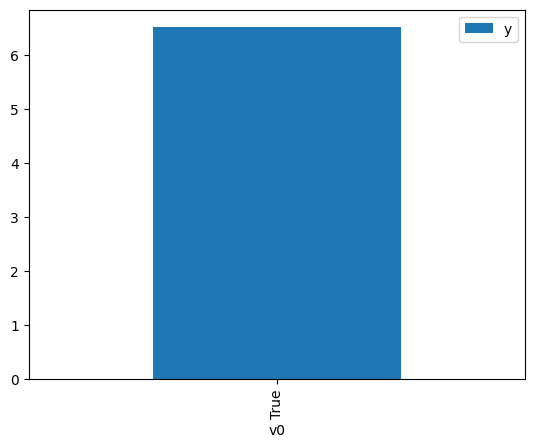

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.529929,False,1.774144,0.321879,3.106757
1,0.601083,False,0.311248,0.300136,3.331818
2,0.458131,False,-0.073143,0.344629,2.901670
3,1.512228,False,1.012716,0.104671,9.553751
4,1.222345,False,4.207092,0.150222,6.656811
...,...,...,...,...,...
995,1.318720,False,4.773735,0.133503,7.490483
996,1.992202,False,4.616561,0.055670,17.963054
997,-0.437050,False,-0.335827,0.653445,1.530351
998,0.529929,False,1.774144,0.321879,3.106757


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.622134,True,6.369524,0.706133,1.416164
1,-1.423049,True,1.091703,0.114994,8.696098
2,1.426200,True,9.084295,0.883258,1.132172
3,1.969890,True,11.148711,0.942633,1.060858
4,0.797400,True,5.966527,0.755227,1.324104
...,...,...,...,...,...
995,0.475066,True,5.945687,0.660806,1.513302
996,0.392773,True,6.540254,0.634020,1.577238
997,0.337204,True,7.159499,0.615439,1.624856
998,0.327837,True,5.574532,0.612272,1.633262


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          1.946e+04
Date:                Wed, 07 Sep 2022   Prob (F-statistic):                        0.00
Time:                        07:45:29   Log-Likelihood:                         -1407.6
No. Observations:                1000   AIC:                                      2819.
Df Residuals:                     998   BIC:                                      2829.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5448      0.036     71.388      0.000       2.475       2.615
x2             4.9453      0.051     96.711      0.000       4.845       5.046
==============================================================================
Omnibus:                        2.718   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.918
Skew:                           0.016   Prob(JB):                        0.232
Kurtosis:                       3.263   Cond. No.                         2.33
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""